# ORFit Regression

# 0. Imports and Load Dataset

In [3]:
# %pip install augly
# %pip install pylibmagic
# %pip install flax
# %pip install tqdm
# %pip install -qq git+https://github.com/probml/dynamax.git

In [2]:
from typing import Sequence
from functools import partial
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
import flax.linen as nn
from jax.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax.distributions import Normal
from tqdm import tqdm

import pylibmagic
from dynamax.utils.datasets import load_1d_synthetic_dataset
from dynamax.rebayes.ekf import RebayesEKF
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.rebayes.orfit import ORFitParams, orthogonal_recursive_fitting

# 1. MLP Model

In [31]:
# Define MLP model that uses gelu activation function
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.gelu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

# 2. Posterior Predictive

## 2.1 ORFit

In [32]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

In [45]:
def orfit_plot_prediction(ax, post_mean, post_basis, apply_fn, featurize_fn, 
                          X_train, y_train, X_eval, y_eval, plot_title=''):
    # Predict
    X_features = vmap(featurize_fn)(X_eval)
    pred_means, pred_covs = vmap(
        orfit_posterior_predictive_moments, (None, 0, None, None)
    )(apply_fn, X_features, post_mean, post_basis)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    ax.plot(X_eval, pred_means, label='mean');
    ax.plot(X_eval, y_eval, 'r--', label='true function')
    ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - jnp.sqrt(pred_covs), pred_means + jnp.sqrt(pred_covs), alpha=0.5, label='1 std');
    # ax.set_xlim(-3.0, 3.0)
    # ax.set_ylim(-5.0, 3.0)
    ax.set_title(plot_title)
    return ax

## 2.2 EKF

In [46]:
def mean_cov_callback(bel, t, x, y):
    return bel.mean, bel.cov

def run_ekf(X, Y, ekf_params, type='fcekf', callback=mean_cov_callback):
    estimator = RebayesEKF(ekf_params, method = type)
    _, filtered_means = estimator.scan(X, Y, callback=callback)

    return filtered_means

In [35]:
def linearized_posterior_predictive_moments_diagonal(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = (F * post_cov) @ F.T + obs_noise

    return pred_mean, pred_cov

In [36]:
def linearized_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = F @ post_cov @ F.T + obs_noise

    return pred_mean, pred_cov


In [37]:
def plot_predictions(X_train, y_train, X_eval, initial_var, emission_var, 
                     flat_params, apply_fn, ekf_type='fcekf'):
    state_dim = flat_params.size
    ekf_params = ParamsGGSSM(
        initial_mean=flat_params,
        initial_covariance=jnp.eye(state_dim) * initial_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim) * 0,
        emission_mean_function = lambda w, x: apply_fn(w, x),
        emission_cov_function = lambda w, x: jnp.array([emission_var]),
    )
    # Train EKF
    ekf_post = run_ekf(X_train, y_train, ekf_params, type=ekf_type)
    ekf_mean, ekf_cov = ekf_post[0][-1], ekf_post[1][-1]

    # Predict
    if len(ekf_cov.shape) == 2:
        posterior_predictive_fn = linearized_posterior_predictive_moments
    else:
        posterior_predictive_fn = linearized_posterior_predictive_moments_diagonal
    pred_means, pred_covs = vmap(
        posterior_predictive_fn, (None, 0, None, None, None)
    )(apply_fn, X_eval, ekf_mean, ekf_cov, emission_var)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    fig, ax = plt.subplots()
    ax.plot(X_eval, pred_means, label='mean');
    ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0 * jnp.sqrt(pred_covs), pred_means + 2.0 * jnp.sqrt(pred_covs), alpha=0.5, label='1 std');
    # ax.set_xlim(-3.0, 3.0)
    # ax.set_ylim(-3.0, 3.0)
    ax.set_title(f'{ekf_type.upper()} predictions')

# 2. Linear Regression

## 2.0 Dataset

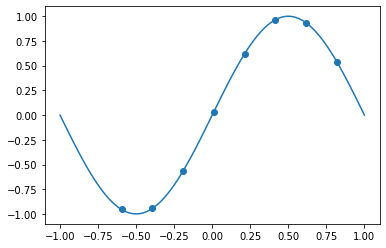

In [100]:
# Sinusoidal Dataset
n_samples = 100
X_lr_grid = jnp.linspace(-1.0, 1.0, n_samples)
y_lr_true = jnp.sin(jnp.pi*X_lr_grid)

# Select some samples as training set
sampled_indices = jr.permutation(jr.PRNGKey(0), jnp.arange(n_samples//5, n_samples, 10))
n_train = len(sampled_indices)
X_lr_train, y_lr_train = X_lr_grid[sampled_indices], y_lr_true[sampled_indices]

fig, ax = plt.subplots()
ax.plot(X_lr_grid, y_lr_true)
ax.scatter(X_lr_train, y_lr_train);

In [101]:
# Feature set is polynomial of order 20
poly_order = 20
def x_to_feature(x, order=poly_order):
    return jnp.power(x, jnp.arange(1, order+1))

X_lr_featurized = vmap(x_to_feature)(X_lr_train)

In [102]:
# Define the linear regression model
input_dim, hidden_dims, output_dim = poly_order, [], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(21,)


In [96]:
# Train ORFit on the dataset
orfit_params = ORFitParams(
    initial_mean=flat_params,
    apply_function=apply_fn,
    loss_function=lambda w, x, y: (apply_fn(w, x) - y) ** 2,
    memory_size=n_train
)
orfit_posterior = orthogonal_recursive_fitting(orfit_params, y_lr_train, X_lr_featurized)

In [103]:
def animate_lr(orfit_posterior, i):
    filtered_means, filtered_bases = orfit_posterior.filtered_means, orfit_posterior.filtered_bases

    ax.cla()

    orfit_plot_prediction(ax, filtered_means[i], filtered_bases[i], apply_fn, 
                          x_to_feature, X_lr_train[:i+1], y_lr_train[:i+1], 
                          X_lr_grid, y_lr_true, 
                          plot_title=f'ORFit Linear Regression ({i+1}/{n_train})')
    ax.set_ylim(-3.0, 3.0)
    
    return ax

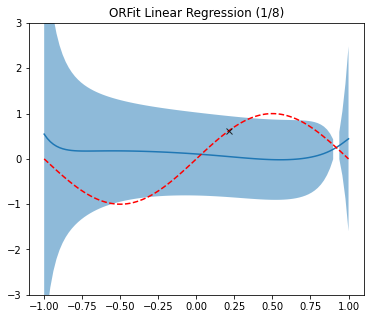

In [104]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, partial(animate_lr, orfit_posterior), frames=5)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [105]:
HTML(anim.to_html5_video())

# 3. Non-Linear Regression

## 3.0 Datasets

In [5]:
n_train=100
n_test=200

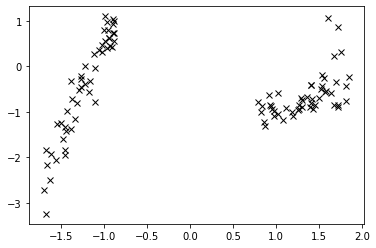

In [6]:
# Dataset 1
(X1_train, y1_train), _ = load_1d_synthetic_dataset(n_train=n_train, n_test=n_test)
X1_train, y1_train = X1_train.squeeze(), y1_train.squeeze()
shuffle_indx = jr.permutation(jr.PRNGKey(0), jnp.arange(X1_train.shape[0]))
X1_train, y1_train = X1_train[shuffle_indx], y1_train[shuffle_indx]
x_grid = jnp.linspace(-3.0, 3.0, 500)

fig, ax = plt.subplots()
ax.plot(X1_train, y1_train, 'kx', label='data');
# ax.plot(X1_test, y1_test, 'rx', label='data')
# ax.set_xlim(-0.5, 1.0)
# ax.set_ylim(-0.5, 1.0);

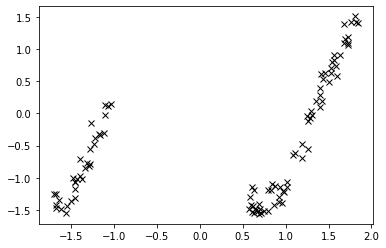

In [7]:
# Dataset 2
key1, key2, subkey1, subkey2 = jr.split(jr.PRNGKey(0), 4)

X2_train = jr.uniform(key1, shape=(2*n_train, 1), minval=-1.0, maxval=1.0)
# X2_test = jr.uniform(key2, shape=(n_test, 1), minval=-1.0, maxval=1.0)

def generating_function(key, x):
    epsilon = jr.normal(key)*0.1
    return -jnp.sin(3/2 * jnp.pi*x) + epsilon

keys_train = jr.split(subkey1, X2_train.shape[0])
# keys_test = jr.split(subkey2, X2_test.shape[0])
y2_train = vmap(generating_function)(keys_train, X2_train)
# y2_test = vmap(generating_function)(keys_test, X2_test)

X2_train = (X2_train - X2_train.mean()) / X2_train.std()
y2_train = (y2_train - y2_train.mean()) / y2_train.std()
# X2_test = (X2_test - X2_test.mean()) / X2_test.std()
# y2_test = (y2_test - y2_test.mean()) / y2_test.std()


sorted_idx = jnp.argsort(X2_train.squeeze())
left_threshold = int(n_train * 1/3)
train_idx = jnp.concatenate([
    sorted_idx[:left_threshold], sorted_idx[left_threshold + n_train:]
])

X2_train, y2_train = X2_train[train_idx], y2_train[train_idx]



fig, ax = plt.subplots()
ax.plot(X2_train, y2_train, 'kx', label='data');
# ax.plot(X2_test, y2_test, 'rx', label='data')
# ax.set_xlim(-0.5, 1.0)
# ax.set_ylim(-0.5, 1.0);

## 3.1 ORFit Performance Evaluation

### 3.1.1 Simple MLP

In [21]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 1, [50,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(151,)


In [33]:
def animate(i, X_train, y_train):
    if i%5==0:
        print(f'Animating {i+1}th iteration...')
    ax.cla()
    # Train ORFit on the dataset
    orfit_params = ORFitParams(
        initial_mean=flat_params,
        apply_function=apply_fn,
        loss_function=lambda w, x, y: (apply_fn(w, x) - y) ** 2,
        memory_size=i+1
    )
    before = time.time()
    orfit_posterior = orthogonal_recursive_fitting(orfit_params, y_train, X_train)
    orfit_filtered_mean = orfit_posterior.filtered_means[-1]
    orfit_filtered_basis = orfit_posterior.filtered_bases[-1]
    print(f'Time taken for step {i+1}: {time.time() - before}')
    orfit_plot_prediction(ax, orfit_filtered_mean, orfit_filtered_basis, apply_fn, 
                          X_train, y_train, x_grid, plot_title=f'ORFit-MLP1 (Memory Size {i+1}/100)')
    
    return ax

animate1 = lambda i: animate(i, X1_train, y1_train)
animate2 = lambda i: animate(i, X2_train, y2_train)

Animating 1th iteration...
Time taken for step 1: 0.6558198928833008


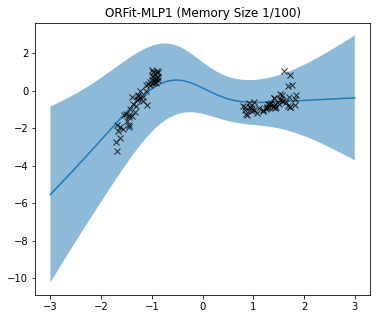

In [34]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, animate1, frames=100)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [35]:
HTML(anim.to_html5_video())

Animating 1th iteration...
Time taken for step 1: 0.6646888256072998
Animating 1th iteration...
Time taken for step 1: 0.6551206111907959
Time taken for step 2: 0.7818489074707031
Time taken for step 3: 0.7853682041168213
Time taken for step 4: 0.7954797744750977
Time taken for step 5: 0.8030276298522949
Animating 6th iteration...
Time taken for step 6: 0.7939751148223877
Time taken for step 7: 0.7861101627349854
Time taken for step 8: 0.791703462600708
Time taken for step 9: 0.7756361961364746
Time taken for step 10: 0.7895536422729492
Animating 11th iteration...
Time taken for step 11: 0.7934319972991943
Time taken for step 12: 0.7883768081665039
Time taken for step 13: 0.7908031940460205
Time taken for step 14: 0.7800545692443848
Time taken for step 15: 1.2474429607391357
Animating 16th iteration...
Time taken for step 16: 0.7916028499603271
Time taken for step 17: 0.7891056537628174
Time taken for step 18: 0.7908780574798584
Time taken for step 19: 0.7874565124511719
Time taken for

Animating 1th iteration...
Time taken for step 1: 0.6413216590881348


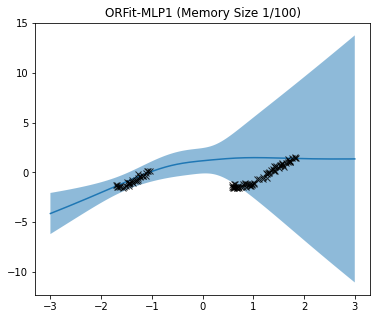

In [36]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, animate2, frames=100)
# anim.save("orfit2_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [37]:
HTML(anim.to_html5_video())

Animating 1th iteration...
Time taken for step 1: 0.6510646343231201
Animating 1th iteration...
Time taken for step 1: 0.6394228935241699
Time taken for step 2: 0.7667269706726074
Time taken for step 3: 0.773679256439209
Time taken for step 4: 0.7835807800292969
Time taken for step 5: 0.7828724384307861
Animating 6th iteration...
Time taken for step 6: 0.771742582321167
Time taken for step 7: 0.7783029079437256
Time taken for step 8: 0.7740652561187744
Time taken for step 9: 0.7755815982818604
Time taken for step 10: 1.3761265277862549
Animating 11th iteration...
Time taken for step 11: 0.809959888458252
Time taken for step 12: 0.7898337841033936
Time taken for step 13: 0.7987711429595947
Time taken for step 14: 0.7977259159088135
Time taken for step 15: 0.7858657836914062
Animating 16th iteration...
Time taken for step 16: 0.767169713973999
Time taken for step 17: 0.7736935615539551
Time taken for step 18: 0.7904434204101562
Time taken for step 19: 0.7906622886657715
Time taken for st

### 3.1.2 More Complex MLP

In [44]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 1, [300, 300, 300,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(181501,)


Animating 1th iteration...
Time taken for step 1: 2.232534170150757


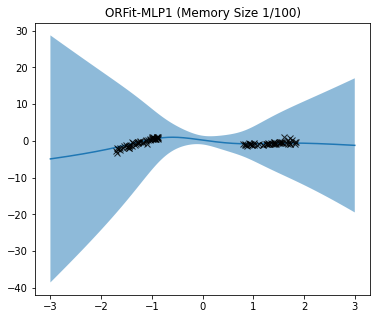

In [45]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, animate1, frames=100)
# anim.save("orfit_mlp1.mp4", dpi=200, bitrate=-1, fps=24)

In [46]:
HTML(anim.to_html5_video())

Animating 1th iteration...
Time taken for step 1: 2.195178747177124
Animating 1th iteration...
Time taken for step 1: 2.1591832637786865
Time taken for step 2: 2.5623953342437744
Time taken for step 3: 4.104394912719727
Time taken for step 4: 2.8166098594665527
Time taken for step 5: 3.12599515914917
Animating 6th iteration...
Time taken for step 6: 3.0496561527252197
Time taken for step 7: 3.248713970184326
Time taken for step 8: 3.1629481315612793
Time taken for step 9: 3.447831392288208
Time taken for step 10: 3.590550184249878
Animating 11th iteration...
Time taken for step 11: 3.8245458602905273
Time taken for step 12: 4.004821062088013
Time taken for step 13: 4.297652959823608
Time taken for step 14: 3.958854913711548
Time taken for step 15: 4.229826211929321
Animating 16th iteration...
Time taken for step 16: 4.178636789321899
Time taken for step 17: 4.372645139694214
Time taken for step 18: 4.671267032623291
Time taken for step 19: 4.892672061920166
Time taken for step 20: 5.18

Animating 1th iteration...
Time taken for step 1: 2.2064802646636963


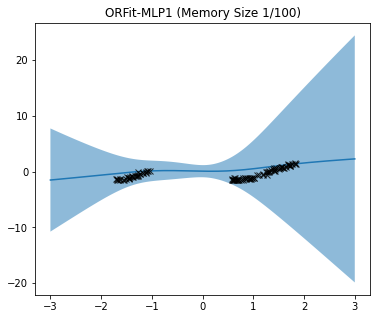

In [47]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, animate2, frames=100)
# anim.save("orfit_mlp1.mp4", dpi=200, bitrate=-1, fps=24)

In [ ]:
HTML(anim.to_html5_video())

Animating 1th iteration...
Time taken for step 1: 2.2284677028656006
Animating 1th iteration...
Time taken for step 1: 2.21277117729187
Time taken for step 2: 2.7210047245025635
Time taken for step 3: 2.7401769161224365
Time taken for step 4: 2.775040864944458
Time taken for step 5: 4.460353851318359
Animating 6th iteration...
Time taken for step 6: 3.2042222023010254
Time taken for step 7: 3.3071436882019043
Time taken for step 8: 3.169157028198242
Time taken for step 9: 3.4938831329345703
Time taken for step 10: 4.060583829879761
Animating 11th iteration...
Time taken for step 11: 3.837486982345581
Time taken for step 12: 4.085013151168823
Time taken for step 13: 4.340663909912109
Time taken for step 14: 3.986814260482788
Time taken for step 15: 4.208348274230957
Animating 16th iteration...
Time taken for step 16: 4.2156617641448975
Time taken for step 17: 4.357848405838013
Time taken for step 18: 4.562853097915649
Time taken for step 19: 4.804639101028442
Time taken for step 20: 5.1